<p style="background:#484E6E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b> Lending Club</b><br>
    <br>Model 01 - Loan Classification in Accepted and Rejected<br><br> 
</p>

<p style="text-align: right;">Module 3: Machine Learning<br>
Sprint 3: Unsupervised Learning & Hyperparameter Tuning<br>
Author : Renato Mariano</p>

<h1 style="color:#484E6E">Introduction </h1>

This data science project aims at automating lending decisions for LendingClub. It is a series of notebooks starting by 01_Data_Sampling_LendingClub.

<h2 style="color:#484E6E">Library Imports and Notebook Setup</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import gc
from rapidfuzz import process
import pydotplus
from IPython.display import Image
from scipy.sparse import issparse

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, recall_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from feature_engine.imputation import CategoricalImputer
import shap

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext blackcellmagic

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="color:#C1524B">Feature Preprocessing</h1>

In [3]:
start = time()
df_train = pd.read_csv("data/exported/full_train.csv", skiprows=lambda x: x % 100)
end = time()
print(f"Read train data with pandas: {(end-start):.3f} sec\n")
print(f"The shape of the data is: {df_train.shape}\n")
df_train.head(5)

Read train data with pandas: 6.232 sec

The shape of the data is: (118439, 9)



,Amount_Requested,Loan_Title,Risk_Score,Debt-To-Income_Ratio,Zip_Code,State,Employment_Length,Policy_Code,Application_Result
0,10000.000,Debt consolidation,NaN,21.160,207xx,MD,< 1 year,0.000,Rejected
1,5000.000,Other,592.000,5.970,150xx,PA,< 1 year,0.000,Rejected
2,1000.000,debt_consolidation,552.000,1.810,212xx,MD,< 1 year,0.000,Rejected
3,10000.000,Major purchase,NaN,207.210,376xx,TN,< 1 year,0.000,Rejected
4,35000.000,Debt consolidation,NaN,100.000,967xx,HI,< 1 year,0.000,Rejected


<h2 style="color:#C1524B">Feature Engineering Pipeline</h2>

Let's start by defining the features and target for our model.

Here we will drop rows where the amount requested is below 1000 USD. And also, drop the Policy code, Zip code and State.

In [4]:
df_train = df_train[df_train["Amount_Requested"] >= 1000]

X_train = df_train.drop(['Application_Result', 'Zip_Code', 'Policy_Code', 'State'], axis=1)
y_train = df_train["Application_Result"].map({"Accepted": 1, "Rejected": 0})

del df_train
gc.collect()

2488

In machine learning, data preprocessing is crucial. We often use **pipelines to automate** these processes. 

Here, we can start defining some of the proceedures that took place on the EDA and that will enter our pipeline Feature Engineering Pipeline.

They include, the creation of the columns has_Income and Provided_Risk_Score, as well as the mapping for the Loan Titles and manually label encoding the Employment Length.

In [5]:
class CreateHasIncomeColumn():
    '''Custom transformer to create 'has_Income' column'''
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['has_Income'] = X[self.column].apply(lambda x: 'yes' if x != -1 else 'no')
        return X


class CreateProvidedRiskScoreColumn():
    '''Custom transformer for creating 'provided_Risk_Score' column and attributing -1 for NA values and for 0 (out of range)'''
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.column][(X[self.column].isna()) | (X[self.column] == 0)] = -1
        X['provided_Risk_Score'] = X[self.column].apply(lambda x: 'no' if x == -1 else 'yes')
        return X


class ApplyMapToLoanTitles():
    '''
    Groups together elements with similar names based on the provided mapping.
    Orginal column is dropped.
    '''
    def __init__(self, column, mapping, similarity_threshold):
        self.column = column
        self.mapping = mapping
        self.similarity_threshold = similarity_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned_column = X[self.column].str.lower().str.strip().str.replace("-", " ").str.replace("_", " ")
        cleaned_column = cleaned_column.apply(lambda x: process.extractOne(x, self.mapping.keys()))
        cleaned_column = cleaned_column.apply(lambda x: self.mapping[x[0]] if x and x[1] >= self.similarity_threshold else "Other")
        
        X = X.drop(self.column, axis=1)
        X['Loan_Title_Grouped'] = cleaned_column
        return X


class ApplyLabelToEmploymentLength():
    '''Change the values in employment length to highlight the natural order of this feature'''
    def __init__(self, column, mapping):
        self.column = column
        self.mapping = mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.column] = X[self.column].map(self.mapping)
        return X      
    

In [6]:
title_mapping = {
    "Debt consolidation": "Debt consolidation",
    "Credit card refinancing": "Credit card",
    "Car": "Car",
    "Major purchase": "Major purchase",
    "Home": "Home",
    "Medical expenses": "Medical expenses",
    "moving": "Moving",
    "business": "Business",
}

empl_length_mapping = {
    "< 1 year": 0,
    "1 year": 1,
    "2 years": 2,
    "3 years": 3,
    "4 years": 4,
    "5 years": 5,
    "6 years": 6,
    "7 years": 7,
    "8 years": 8,
    "9 years": 9,
    "10+ years": 10,
}

feat_eng_pipe = Pipeline(
    steps=[
        ('create_has_income', CreateHasIncomeColumn(column='Debt-To-Income_Ratio')),
        ('create_provided_risk_score', CreateProvidedRiskScoreColumn(column="Risk_Score")),
        ('map_loan_titles', ApplyMapToLoanTitles(column="Loan_Title", mapping=title_mapping, similarity_threshold=60)),
        ('map_empl_length', ApplyLabelToEmploymentLength(column="Employment_Length", mapping=empl_length_mapping))
    ]
)

X_train_FeatEng = feat_eng_pipe.fit_transform(X_train, y_train)

In [7]:
X_train_FeatEng.head(8)

,Amount_Requested,Risk_Score,Debt-To-Income_Ratio,Employment_Length,has_Income,provided_Risk_Score,Loan_Title_Grouped
0,10000.000,-1.000,21.160,0.000,yes,no,Debt consolidation
1,5000.000,592.000,5.970,0.000,yes,yes,Other
2,1000.000,552.000,1.810,0.000,yes,yes,Debt consolidation
3,10000.000,-1.000,207.210,0.000,yes,no,Major purchase
4,35000.000,-1.000,100.000,0.000,yes,no,Debt consolidation
5,20000.000,-1.000,13.460,0.000,yes,no,Credit card
6,10000.000,-1.000,24.850,0.000,yes,no,Debt consolidation
7,2000.000,-1.000,11.450,5.000,yes,no,Debt consolidation


<h1 style="color:#C1524B">Baseline Model</h1>

How much would a **model at random guessing** score for our dataset.

In [8]:
dummy = DummyClassifier(random_state=1, strategy="stratified")
dummy.fit(X_train_FeatEng, y_train)
dummy.score(X_train_FeatEng, y_train)

0.8601271647991624

For this baseline model a **86% accuracy** was obtained. 

Let's check the accuracy as well for a **logistic model**, for that a simple encoder was applied to the X train engineered data so that the model could interpret the categorical classes.

In [9]:
label_encoder = LabelEncoder()
logreg = LogisticRegression(random_state=1)
logreg.fit(X_train_FeatEng.apply(label_encoder.fit_transform), y_train)

yhat_train = logreg.predict(X_train_FeatEng.apply(label_encoder.fit_transform))
report = classification_report(y_train, yhat_train)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    109474
           1       0.71      0.59      0.65      8955

    accuracy                           0.95    118429
   macro avg       0.84      0.79      0.81    118429
weighted avg       0.95      0.95      0.95    118429



As expected the **accurary** for a model not at random is much higher **95%**. Which can be obtained simply by setting **most of the dataset to the dominant class**.

This model, however **perfoms relatively well in terms of precision and recall** for the non-dominant class (72% and 59% respectively).

Let's further improve the quality of our data in our preprocessing pipeline.

<h2 style="color:#C1524B">Preprocessing Pipeline</h2>

This pipeline will be responsible for:
- RareEncoding followed by for the One-Hot-Encoding for the cat_features with higher cardinality (reduction of cardinality).
- SimpleEncoder for the newly created binary_features. 
- RobustScaler for the continous features (outliers in the dataset).

A fill for the remaining null values with mode/median will also be implemented.

In [10]:
num_features = ["Amount_Requested", "Risk_Score", "Debt-To-Income_Ratio"]
binary_features = ["has_Income", "provided_Risk_Score"]
cat_features = ["Loan_Title_Grouped"]
remaining_features = ["Employment_Length"]

num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ('robust_scaler', RobustScaler(with_centering=True, with_scaling=True)),
    ]
)

binary_transformer = Pipeline(
    steps=[
        ("cat_mode_imputer", CategoricalImputer(imputation_method="frequent", ignore_format=True)),
        ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ]
)

cat_transformer = Pipeline(
    steps=[
        ("cat_mode_imputer", CategoricalImputer(imputation_method="frequent", ignore_format=True)),
        ("rare_encoder", RareLabelEncoder(tol=0.02, n_categories=1)),
        ("one_hot_encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ]
)

remaining_transformer = Pipeline(
    steps=[
        ("cat_mode_imputer", CategoricalImputer(imputation_method="frequent", ignore_format=True)),
    ]
)

In [11]:
preprocess_pipe = ColumnTransformer(
   transformers=[
       ('num', num_transformer, num_features),
       ('bin', binary_transformer, binary_features),
       ('remain', remaining_transformer, remaining_features),
       ('cat', cat_transformer, cat_features),
    ]
)

preprocess_pipe.set_output(transform="pandas")

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust_scaler',
                                                  RobustScaler())]),
                                 ['Amount_Requested', 'Risk_Score',
                                  'Debt-To-Income_Ratio']),
                                ('bin',
                                 Pipeline(steps=[('cat_mode_imputer',
                                                  CategoricalImputer(ignore_format=True,
                                                                     imputation_method='frequent')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unkn...
                                                  CategoricalImputer(ignore_format=True,
                                                                     imputation_method='frequent'))]),
                                 ['Employment_Length']),
                                ('cat',
                                 Pipeline(steps=[('cat_mode_imputer',
                                                  CategoricalImputer(ignore_format=True,
                                                                     imputation_method='frequent')),
                                                 ('rare_encoder',
                                                  RareLabelEncoder(n_categories=1,
                                                                   tol=0.02)),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Loan_Title_Grouped'])])

In [12]:
X_train_preprocess = preprocess_pipe.fit_transform(X_train_FeatEng)
X_train_preprocess.head()

,num__Amount_Requested,num__Risk_Score,num__Debt-To-Income_Ratio,bin__has_Income,bin__provided_Risk_Score,remain__Employment_Length,cat__Loan_Title_Grouped_Business,cat__Loan_Title_Grouped_Credit card,cat__Loan_Title_Grouped_Debt consolidation,cat__Loan_Title_Grouped_Home,cat__Loan_Title_Grouped_Major purchase,cat__Loan_Title_Grouped_Medical expenses,cat__Loan_Title_Grouped_Moving,cat__Loan_Title_Grouped_Other,cat__Loan_Title_Grouped_Rare
0,0.000,0.000,0.051,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
1,-0.333,0.946,-0.526,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,-0.600,0.882,-0.684,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,7.114,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
4,1.667,0.000,3.044,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000


Now that we have fully functioning pipelines, we can jump into the selection of models and hyperparameter tuning.

<h1 style="color:#C1524B">Model Selection</h1>

The following modeling solutions were defined. We start off by **setting the hyperparameters for the RandomSearch** for each of the defined models. The GridSearch is the responsible to find the best hyperparameters for each model while **it performs a cross-validation**. We used 5 cross-folds.

In [13]:
# Update the param_grids to include distributions for randomized search
param_distributions = {
    'LogisticRegression': {
        'model__C': uniform(0.01, 1.0)
    },
    'DecisionTree': {
        'model__max_depth': randint(2, 5),
        'model__min_samples_leaf': randint(30, 101)
    },
    'RandomForest': {
        'model__n_estimators': randint(10, 51),
        'model__max_depth': randint(2, 5),
        'model__min_samples_leaf': randint(15, 101)
    },
    'XGBoost': {
        'model__n_estimators': randint(10, 51),
        'model__learning_rate': uniform(0.01, 0.05),
        'model__max_depth': randint(2, 5)
    },
}

models = [
    ('LogisticRegression', LogisticRegression(random_state=1, class_weight='balanced')),
    ('DecisionTree', DecisionTreeClassifier(random_state=1, class_weight='balanced')),
    ('RandomForest', RandomForestClassifier(random_state=1, class_weight='balanced')),
    ('XGBoost', XGBClassifier(random_state=1, class_weight='balanced')),
]


In [14]:
results = {}

# Iterate through the models and train them using randomized search
for model_name, model in models:
    model_pipeline = Pipeline([
        ('model', model)
    ])

    param_dist = param_distributions.get(model_name, {})
    randomized_search = RandomizedSearchCV(model_pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1', random_state=1)
    randomized_search.fit(X_train_preprocess, y_train)

    results[model_name] = {
        'model': randomized_search.best_estimator_,
        'best_params': randomized_search.best_params_,
        'best_score': randomized_search.best_score_
    }

In [15]:
#results

In [16]:
print("Model F1-Scores:\n")
for model_name, result in results.items():
    print(f"{model_name}: {result['best_score']:.3}")

Model F1-Scores:

LogisticRegression: 0.646
DecisionTree: 0.681
RandomForest: 0.668
XGBoost: 0.825


As we can see, our models perfom very good at the provided task. **All presenting f1-score above 0.95** for the majority class. The best model was obtained with an XGBoost.

Although these are coefficients provided in a cross-validation setting, **due to our large amount of data, we will use a separate validation set to check the results**.

We will start by cleaning some of the variables on the memory, loading the validation dataset and applying the necessary pipelines.

In [17]:
del X_train_FeatEng, X_train_preprocess, y_train, yhat_train
gc.collect()

549

In [18]:
start = time()
df_valid = pd.read_csv("data/exported/full_validation.csv", skiprows=lambda x: x % 100)
end = time()
print(f"Read accepted train with pandas: {(end-start):.3f} sec\n")
print(f"The shape of the data is: {df_valid.shape}\n")
df_valid.head(5)

Read accepted train with pandas: 5.219 sec

The shape of the data is: (88829, 9)



,Amount_Requested,Loan_Title,Risk_Score,Debt-To-Income_Ratio,Zip_Code,State,Employment_Length,Policy_Code,Application_Result
0,25000.000,Credit card refinancing,NaN,23.740,109xx,NY,< 1 year,0.000,Rejected
1,25000.000,Other,NaN,2.540,104xx,NY,< 1 year,0.000,Rejected
2,10000.000,Debt consolidation,792.000,7.990,941xx,CA,3 years,1.000,Accepted
3,15500.000,Other,NaN,100.000,144xx,NY,< 1 year,0.000,Rejected
4,14000.000,major_purchase,NaN,8.090,104xx,NY,< 1 year,0.000,Rejected


In [19]:
df_valid = df_valid[df_valid["Amount_Requested"] >= 1000]

X_valid = df_valid.drop(['Application_Result', 'Zip_Code', 'Policy_Code'], axis=1)
y_valid = df_valid["Application_Result"].map({"Accepted": 1, "Rejected": 0})

In [20]:
X_valid_FeatEng = feat_eng_pipe.fit_transform(X_valid, y_valid)
X_valid_preprocess = preprocess_pipe.fit_transform(X_valid_FeatEng)
X_valid_preprocess.head()

,num__Amount_Requested,num__Risk_Score,num__Debt-To-Income_Ratio,bin__has_Income,bin__provided_Risk_Score,remain__Employment_Length,cat__Loan_Title_Grouped_Business,cat__Loan_Title_Grouped_Credit card,cat__Loan_Title_Grouped_Debt consolidation,cat__Loan_Title_Grouped_Home,cat__Loan_Title_Grouped_Major purchase,cat__Loan_Title_Grouped_Medical expenses,cat__Loan_Title_Grouped_Moving,cat__Loan_Title_Grouped_Other,cat__Loan_Title_Grouped_Rare
0,1.000,0.000,0.155,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,0.000,-0.653,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,0.000,1.263,-0.445,1.000,1.000,3.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.367,0.000,3.060,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
4,0.267,0.000,-0.441,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000


Let's define variables for our best models and run the predictions

In [21]:
logreg_model = results['LogisticRegression']['model'].named_steps['model']
dt_model = results['DecisionTree']['model'].named_steps['model']
rf_model = results['RandomForest']['model'].named_steps['model']
xgb_model = results['XGBoost']['model'].named_steps['model']

y_logreg = logreg_model.predict(X_valid_preprocess)
y_dt = dt_model.predict(X_valid_preprocess)
y_rf = rf_model.predict(X_valid_preprocess)
y_xgb = xgb_model.predict(X_valid_preprocess)

# predict probabilities
probs_logreg = logreg_model.predict_proba(X_valid_preprocess)[:, 1]
probs_dt = dt_model.predict_proba(X_valid_preprocess)[:, 1]
probs_rf = rf_model.predict_proba(X_valid_preprocess)[:, 1]
probs_xgb = xgb_model.predict_proba(X_valid_preprocess)[:, 1]

Let's evaluate these models first based on their f1-score and recall and then jump to the confusion matrices.

In [22]:
models = {
    'LogisticRegression': (y_logreg, probs_logreg),
    'DecisionTree': (y_dt, probs_dt),
    'RandomForest': (y_rf, probs_rf),
    'XGBoost': (y_xgb, probs_xgb),
}

for model_name, y_pred in models.items():
    f1 = f1_score(y_valid, y_pred[0])
    recall = recall_score(y_valid, y_pred[0])
    
    print(f"{model_name}")
    print(f"F1-Score: {f1:.3f} ; Recall: {recall:.3f}\n")

LogisticRegression
F1-Score: 0.652 ; Recall: 0.965

DecisionTree
F1-Score: 0.652 ; Recall: 0.914

RandomForest
F1-Score: 0.641 ; Recall: 0.918

XGBoost
F1-Score: 0.789 ; Recall: 0.767



The F1-Scores are very similar as for the training dataset. Highlighting that our models are not overfitting and simply predicting well. The XGBoost is kept as the best model with 0.98 recall.

Let's see the results in a **confusion matrix**. The values exposed there are normalized and represent percentages in relation to true values.

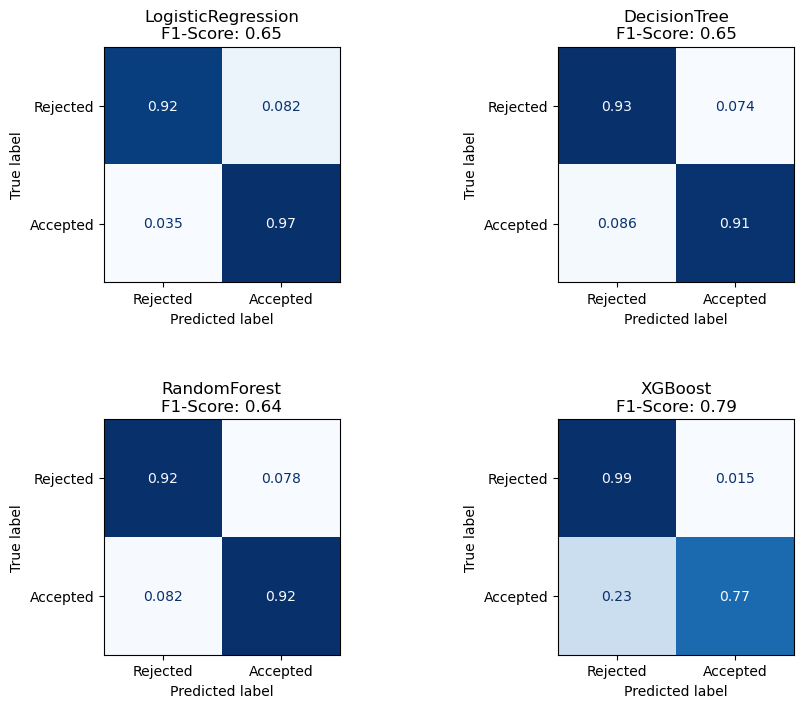

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for model_name, y_pred, ax in zip(models.keys(), models.values(), axes.flatten()):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_valid, y_pred[0], normalize='true',
                                                                  cmap='Blues', ax=ax, colorbar=False,
                                                                  display_labels=["Rejected", "Accepted"])
    f1 = f1_score(y_valid, y_pred[0])
    ax.set_title(f"{model_name}\nF1-Score: {f1:.2f}")

plt.tight_layout(pad=4)

These confusion matrices provided a good example of the importance of checking several metrics before choosing a model. As we can see, the XGBoost model does not perform so well for the minority class (84% correctly predicted as accepted).

All of the other models perform very well on both classes and solely based on that could be chosen as our model. The logistic regression performs slightly better at predicting clients who should have their loan accepted. Let's further evaluate before making a decision. 

Let's check the results in a **ROC_AUC Curve** to have another visual representation of the results.

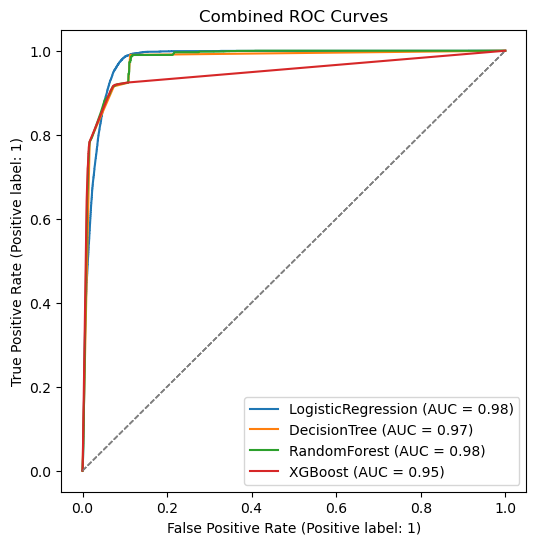

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_displays = []

for model_name, y_pred in models.items():
    roc_display = RocCurveDisplay.from_predictions(y_valid, y_pred[1], name=model_name, ax=ax)
    roc_displays.append(roc_display)
    ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

ax.set_title("Combined ROC Curves");

These curves depict a very similar curve for the DecisionTree and XGBoost models. The LogisticRegression presents the highest area under the curve, along with the RandomForest.

Let's see some **features importance** for some of these models. Starting off by checking the tree for the decision tree model.

The following distributions are used as reference for the values in the tree.

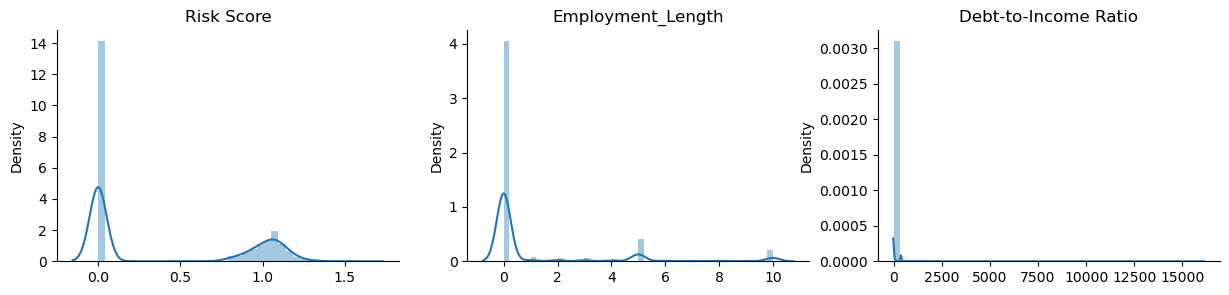

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

sns.distplot(x=X_valid_preprocess["num__Risk_Score"], ax=axes[0])
sns.distplot(x=X_valid_preprocess["remain__Employment_Length"], ax=axes[1])
sns.distplot(x=X_valid_preprocess["num__Debt-To-Income_Ratio"], ax=axes[2])

axes[0].set(title="Risk Score")
axes[1].set(title="Employment_Length")
axes[2].set(title="Debt-to-Income Ratio")
ax.set(xlabel="")
sns.despine()

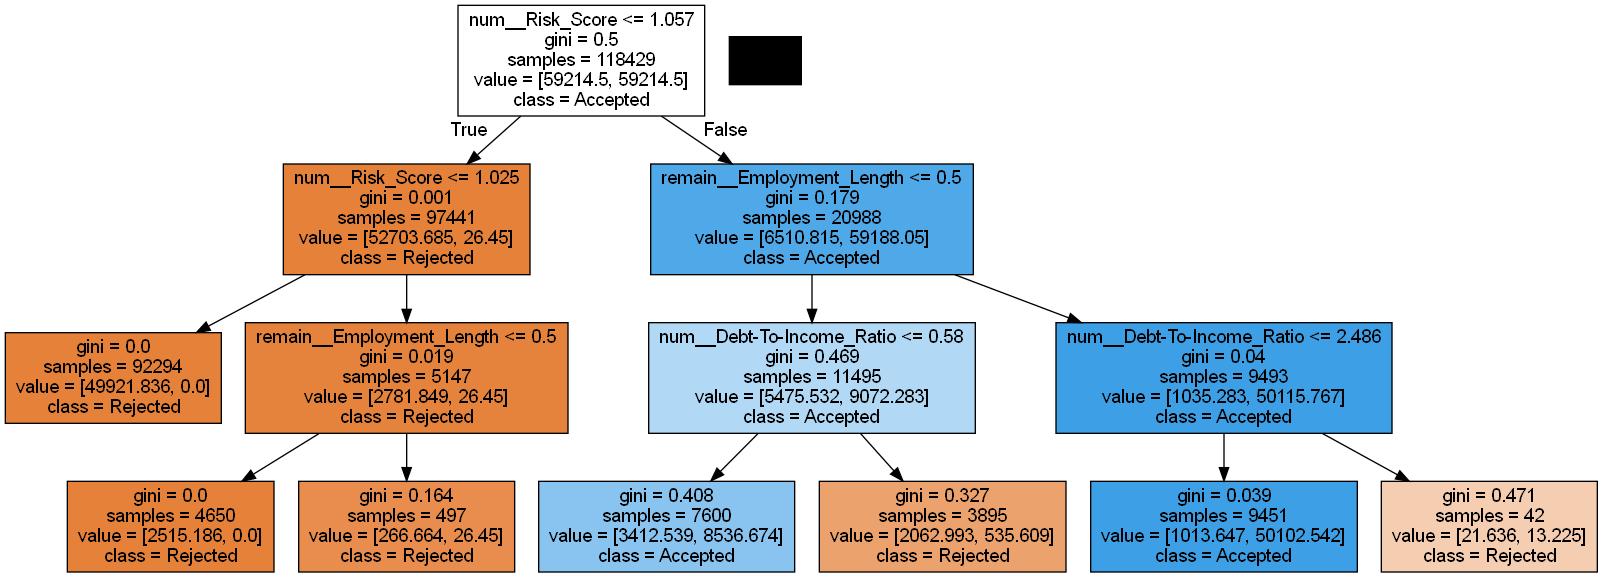

In [26]:
# Create DOT data
dot_data = export_graphviz(dt_model,
                           out_file=None,
                           feature_names=X_valid_preprocess.columns,
                           class_names=['Rejected', 'Accepted'],
                           filled = True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

After the application of the RobustScaler on the features, it is a bit harder to evaluate the decisions of the tree. In general lines, the most important feature to base decisions was the Risk_Score, followed by the Employment Length and the Debt-to-Income ratio.

Clients with low/non-provided risk score are being rejected. Rares Loan titles seems to also have influenced the tree toward rejecting the loans (those represent unclear/no given information on the reason for the loan). On the right side, the tree passes through the employment length, but seems to oversee something clear to humans - clients with low/no employment time should be rejected. It then evaluates the Debt-to-income ratio and we see that clients with very low proportional debts are accepted.

Let's see a **permutation importance for the logistic regression**.

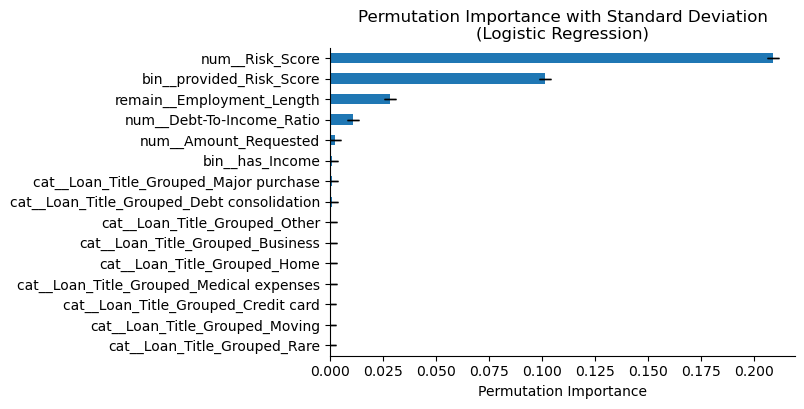

In [27]:
result = permutation_importance(logreg_model, X_valid_preprocess, y_valid, n_repeats=5, random_state=1)

feature_importance = pd.DataFrame(
    {
        "Feature": X_valid_preprocess.columns,
        "Importance": result.importances_mean,
        "Standard Deviation": result.importances_std,
    }
)
mask = feature_importance['Importance']<0
feature_importance['Importance'][mask] = feature_importance['Importance'][mask] * -1
feature_importance = feature_importance.sort_values("Importance", ascending=True)

ax = feature_importance.plot(
    x="Feature",
    y="Importance",
    kind="barh",
    color="tab:blue",
    figsize=(6, 4),
    yerr="Standard Deviation",
    capsize=4,
)

sns.despine()
ax.set(
    ylabel="",
    xlabel="Permutation Importance",
    title="Permutation Importance with Standard Deviation\n(Logistic Regression)",
)
ax.legend([], frameon=False);

**For our simplest model**, the feature that most **influenced** the acceptance of a loan was also the **Risk Score**. It is followed by the engineered provided_Risk_Score and by the Employment length.

For the features importance in our **RandomForest and XGBoost we will use the library SHAP** (SHapley Additive exPlanations), which is a unified approach to explain the output of any machine learning model based on game theory.

In [28]:
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_valid_preprocess)

explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_valid_preprocess)

In [29]:
# XGBooster
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0,:], X_valid_preprocess.iloc[0,:])

In [30]:
# RandomForest
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1][0,:], X_valid_preprocess.iloc[0,:])

The above plots show the features contributing to take the SHAP value to the right/left. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

We see that for **both models, the importances are given to similar features**. **We will evaluate further the RandomForest** since the XGBoost did not perform well in predicting the Accepted class.

Bellow we see the importance of the feature in SHAP value and **how the importance of the feature changes with the increase of its values**.

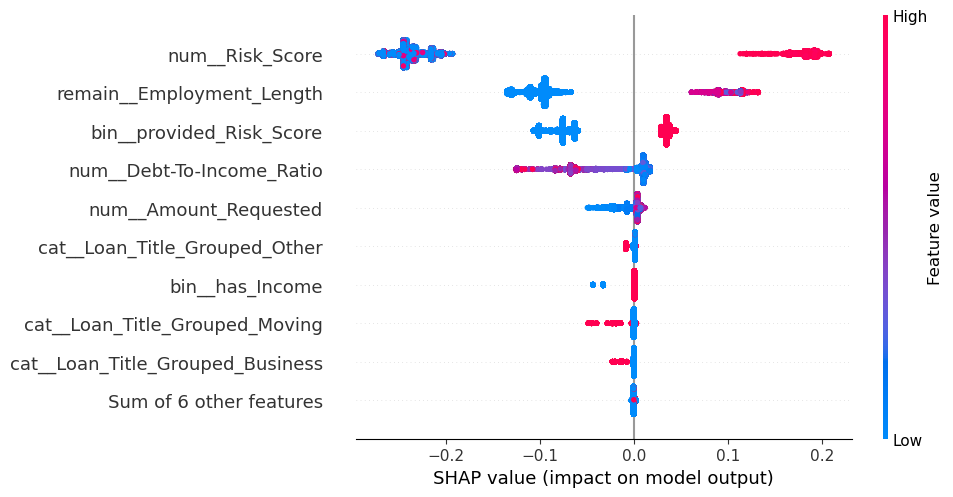

In [31]:
shap.plots.beeswarm(explainer_rf(X_valid_preprocess)[:,:,1])

With the above plot we see again how much importance the Risk Score presents to this model (impact on the SHAP value).
We can also see that High Risk Score values (left side) was very important for the model decisions. On the right side this feature has mixed values (high and low), but also important for the model's decisions.


<h1 style="color:#C1524B">Final Model Evaluation</h1>

After, careful evaluation of our models, we decided to implement a Random Forest. Effectivelly, all of the used models presented very good performances for our task (even the XGBoost). 

The decision tree and the random forest models presented the same ROC AUC value 0.99 and similar performance in relation to other parameters (f1-score, accuracy). The decision tree will be used due to its easy explainability.

Let's check the results in the test dataset.

In [32]:
del X_valid_FeatEng, X_valid_preprocess, y_valid
gc.collect()

12379

In [33]:
start = time()
df_test = pd.read_csv("data/exported/full_test.csv", skiprows=lambda x: x % 100) #
end = time()
print(f"Read accepted train with pandas: {(end-start):.3f} sec\n")
print(f"The shape of the data is: {df_test.shape}\n")
df_test.head(5)

Read accepted train with pandas: 4.487 sec

The shape of the data is: (88829, 9)



,Amount_Requested,Loan_Title,Risk_Score,Debt-To-Income_Ratio,Zip_Code,State,Employment_Length,Policy_Code,Application_Result
0,2000.000,Other,NaN,9.200,339xx,FL,NaN,0.000,Rejected
1,5000.000,Debt consolidation,NaN,18.440,301xx,GA,< 1 year,0.000,Rejected
2,18000.000,Debt consolidation,747.000,7.560,194xx,PA,< 1 year,1.000,Accepted
3,20000.000,Debt consolidation,613.000,0.940,908xx,CA,2 years,0.000,Rejected
4,2300.000,Other,642.000,28.870,851xx,AZ,< 1 year,0.000,Rejected


In [34]:
df_test = df_test[df_test["Amount_Requested"] >= 1000]

X_test = df_test.drop(['Application_Result', 'Zip_Code', 'Policy_Code'], axis=1)
y_test = df_test["Application_Result"].map({"Accepted": 1, "Rejected": 0})

In [35]:
X_test_FeatEng = feat_eng_pipe.fit_transform(X_test, y_test)
X_test_preprocess = preprocess_pipe.fit_transform(X_test_FeatEng)
X_test_preprocess.head()

,num__Amount_Requested,num__Risk_Score,num__Debt-To-Income_Ratio,bin__has_Income,bin__provided_Risk_Score,remain__Employment_Length,cat__Loan_Title_Grouped_Business,cat__Loan_Title_Grouped_Credit card,cat__Loan_Title_Grouped_Debt consolidation,cat__Loan_Title_Grouped_Home,cat__Loan_Title_Grouped_Major purchase,cat__Loan_Title_Grouped_Medical expenses,cat__Loan_Title_Grouped_Moving,cat__Loan_Title_Grouped_Other,cat__Loan_Title_Grouped_Rare
0,-0.533,0.000,-0.392,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
1,-0.333,0.000,-0.043,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.533,1.195,-0.454,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.667,0.981,-0.704,1.000,1.000,2.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
4,-0.513,1.027,0.351,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000


Let's run the predictions on the processed test data.

In [36]:
yhat_test = dt_model.predict(X_test_preprocess)
report = classification_report(y_test, yhat_test, target_names=['Accepted', 'Rejected'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Accepted       1.00      0.92      0.96     82038
    Rejected       0.52      0.99      0.68      6784

    accuracy                           0.93     88822
   macro avg       0.76      0.96      0.82     88822
weighted avg       0.96      0.93      0.94     88822



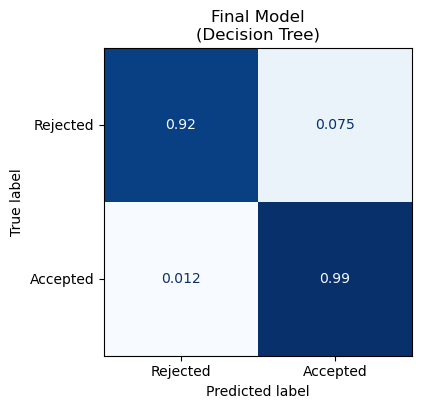

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, yhat_test, normalize='true',
                                                                  cmap='Blues', ax=ax, colorbar=False, 
                                                                  display_labels=["Rejected", "Accepted"])
f1 = f1_score(y_test, yhat_test)
ax.set_title(f"Final Model\n(Decision Tree)");

We can see that for our test data, the model do not perform as well as on the previous dataset; the precision for the minority class is reduced, it could however maintain a good level of right predictions with recall of 99% and 93%.

<h1 style="color:#C1524B">Model Deployment</h1>

In [38]:
import pickle

with open('loan_app/feat_eng_pipe-0.1.0.pkl', 'wb') as file:
    pickle.dump(feat_eng_pipe, file)

with open('loan_app/preprocess_pipe-0.1.0.pkl', 'wb') as file:
    pickle.dump(preprocess_pipe, file)

with open('loan_app/dt_model-0.1.0.pkl', 'wb') as file:
    pickle.dump(dt_model, file)

<h1 style="color:#C1524B">Conclusion - Rejected and Accepted Loans</h1>

The prediction of loans into Accepted and Rejected seemed like an easy task to which a simple machine learning model is very suitable to do. Our decision tree model proved to classify the requests correctly 93% of the time as rejected and 99% of the time as accepted.